In [1]:
import os
import geopandas as gpd
import numpy as np
import blocksnet
import pulp
from pulp import LpMaximize,LpMinimize, LpProblem, LpStatus, lpSum, LpVariable

import pandas as pd
import matplotlib.pyplot as plt
from shapely import Point

import warnings
warnings.filterwarnings('ignore')

local_crs = 32636
example_data_path = "./my_data"

d:\urban_project\blocksnet\.venv\Lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\tihvv\AppData\Local\Temp\ipykernel_5712\2715607546.py:2: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, i

In [2]:
blocks = gpd.read_parquet(os.path.join(example_data_path, 'blocks_cutter_result.parquet')).to_crs(local_crs)
houses = gpd.read_file(os.path.join(example_data_path, "house_points.geojson")).to_crs(local_crs)
buildings = gpd.read_parquet(os.path.join(example_data_path, "all_buildings_spb.parquet")).to_crs(local_crs)
accessibility_matrix = pd.read_pickle(os.path.join(example_data_path, "accs_matrix.pickle"))
schools = gpd.read_file(os.path.join(example_data_path, "schools.geojson")).to_crs(local_crs)
kindergartens = gpd.read_file(os.path.join(example_data_path, "kindergartens.geojson")).to_crs(local_crs)
multifunctional_centers = gpd.read_file(os.path.join(example_data_path, "multifunctional_centers.geojson")).to_crs(local_crs)
hospitals = gpd.read_file(os.path.join(example_data_path, "hospitals.geojson")).to_crs(local_crs)
policlinics = gpd.read_file(os.path.join(example_data_path, "policlinics.geojson")).to_crs(local_crs)

In [3]:
houses = houses.loc[houses['Iq'] > 0.3]
houses = houses.loc[houses['accs_time'] <= 35]
houses

,avg_m2_price_rent,mean_price_rent,P_clinic,P_hospitals,P_kindergarten,P_mfc,P_schools,accs_time,log_accs_time,Iq,P_avg,Idx,geometry
2,708.573345,44666.0,1,1,1.000000,0.0,1.0,10.0,1.00,0.50,0.800000,0.650000,POINT (342768.230 6637807.041)
3,538.461538,35000.0,1,1,1.000000,0.0,1.0,10.0,1.00,0.61,0.800000,0.705000,POINT (342687.422 6637725.165)
5,696.376036,45721.0,1,1,1.000000,1.0,1.0,16.4,1.21,0.38,1.000000,0.690000,POINT (343448.595 6636377.427)
6,700.211581,48353.0,1,1,0.807692,0.0,1.0,10.0,1.00,0.46,0.761538,0.610769,POINT (345115.650 6637867.922)
7,722.163203,45861.0,1,1,1.000000,0.0,1.0,17.4,1.24,0.37,0.800000,0.585000,POINT (347142.595 6640988.459)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1412,757.575758,25000.0,1,1,0.000000,0.0,0.0,31.1,1.49,0.58,0.400000,0.490000,POINT (350613.104 6636768.823)
1416,760.000000,38000.0,1,1,1.000000,0.0,0.0,31.9,1.50,0.37,0.600000,0.485000,POINT (350904.187 6636778.345)
1424,611.111111,22000.0,1,1,1.000000,1.0,0.0,32.3,1.51,0.64,0.800000,0.720000,POINT (351346.406 6636680.197)
1426,787.037037,21250.0,1,1,1.000000,1.0,0.0,32.3,1.51,0.64,0.800000,0.720000,POINT (351543.744 6636547.355)


In [4]:
houses_pol = houses.copy()
houses_pol['geometry'] = houses['geometry'].apply(lambda x: x.buffer(0.001))  # Преобразование точек в небольшие полигоны

# Выполнение пространственного объединения для определения, в каких кварталах находятся дома
overlay = gpd.overlay(blocks, houses_pol, how="intersection")

unique_blocks_ids = overlay["id"].unique()

blocks_with_houses = blocks[blocks["id"].isin(unique_blocks_ids)]
blocks_with_houses.reset_index(drop= True, inplace= True )
blocks_with_houses.shape[0]

119

In [18]:
filtered_accessibility_matrix = accessibility_matrix.loc[blocks['id'].tolist(), blocks_with_houses['id'].tolist()]
filtered_accessibility_matrix.shape

(17010, 119)

In [19]:
filtered_accessibility_matrix

id,2854,3326,3331,3503,3504,3506,3509,3511,3512,3513,...,8580,8582,8855,8856,8864,9154,9162,9178,9812,10430
id,,,,,,,,,,,,,,,,,,,,,
0,161.2,151.5,154.4,154.2,151.2,150.6,146.2,147.4,149.7,151.7,...,115.3,114.4,111.8,111.2,111.7,104.5,109.3,112.5,105.2,104.8
1,161.2,151.5,154.4,154.2,151.2,150.6,146.2,147.4,149.7,151.7,...,115.3,114.4,111.8,111.2,111.7,104.5,109.3,112.5,105.2,104.8
2,161.2,151.5,154.4,154.2,151.2,150.6,146.2,147.4,149.7,151.7,...,115.3,114.4,111.8,111.2,111.7,104.5,109.3,112.5,105.2,104.8
3,169.3,159.6,162.5,162.3,159.3,158.7,154.3,155.5,157.8,159.8,...,123.4,122.5,119.9,119.3,119.8,112.6,117.4,120.6,113.3,112.9
4,160.9,151.2,154.1,153.9,150.9,150.3,145.9,147.1,149.4,151.4,...,115.0,114.1,111.5,110.9,111.4,104.2,109.0,112.2,104.9,104.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17005,117.8,108.1,111.0,110.8,107.8,107.2,102.8,104.0,106.3,108.3,...,67.5,69.8,70.4,66.2,64.9,64.0,68.8,65.0,64.7,64.3
17006,110.9,101.2,104.1,103.9,100.9,100.3,95.9,97.1,99.4,101.4,...,60.6,62.9,63.5,59.3,58.0,57.1,61.9,58.1,57.8,57.4
17007,114.0,104.3,107.2,107.0,104.0,103.4,99.0,100.2,102.5,104.5,...,63.7,66.0,66.6,62.4,61.1,60.2,65.0,61.2,60.9,60.5


In [20]:
blocks_with_houses['x'] = blocks_with_houses.centroid.x # добавляем столбец с x-координатами центроидов
blocks_with_houses['y'] = blocks_with_houses.centroid.y # добавляем столбец с y-координатами центроидов
houses_xy = np.asarray(blocks_with_houses[['x', 'y']]) # преобразуем столбцы в массив numpy

blocks['x'] = blocks.centroid.x # добавляем столбец с x-координатами центроидов
blocks['y'] = blocks.centroid.y # добавляем столбец с y-координатами центроидов
services_xy = np.asarray(blocks[['x', 'y']]) # преобразуем столбцы в массив numpy

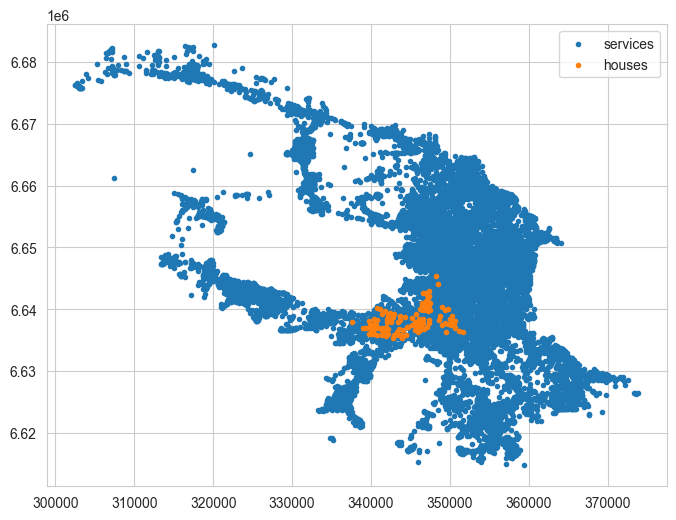

In [9]:
fig = plt.figure(figsize = (8, 6))

plt.scatter(services_xy[:,0],services_xy[:,1], s=9, label = 'services')
plt.scatter(houses_xy[:,0],houses_xy[:,1], s=9, label = 'houses')

plt.legend()
plt.show()

In [22]:
filtered_accessibility_matrix.columns = range(len(filtered_accessibility_matrix.columns))
filtered_accessibility_matrix.reset_index(drop=True, inplace=True)
filtered_accessibility_matrix

,0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,115,116,117,118
0,161.2,151.5,154.4,154.2,151.2,150.6,146.2,147.4,149.7,151.7,...,115.3,114.4,111.8,111.2,111.7,104.5,109.3,112.5,105.2,104.8
1,161.2,151.5,154.4,154.2,151.2,150.6,146.2,147.4,149.7,151.7,...,115.3,114.4,111.8,111.2,111.7,104.5,109.3,112.5,105.2,104.8
2,161.2,151.5,154.4,154.2,151.2,150.6,146.2,147.4,149.7,151.7,...,115.3,114.4,111.8,111.2,111.7,104.5,109.3,112.5,105.2,104.8
3,169.3,159.6,162.5,162.3,159.3,158.7,154.3,155.5,157.8,159.8,...,123.4,122.5,119.9,119.3,119.8,112.6,117.4,120.6,113.3,112.9
4,160.9,151.2,154.1,153.9,150.9,150.3,145.9,147.1,149.4,151.4,...,115.0,114.1,111.5,110.9,111.4,104.2,109.0,112.2,104.9,104.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17005,117.8,108.1,111.0,110.8,107.8,107.2,102.8,104.0,106.3,108.3,...,67.5,69.8,70.4,66.2,64.9,64.0,68.8,65.0,64.7,64.3
17006,110.9,101.2,104.1,103.9,100.9,100.3,95.9,97.1,99.4,101.4,...,60.6,62.9,63.5,59.3,58.0,57.1,61.9,58.1,57.8,57.4
17007,114.0,104.3,107.2,107.0,104.0,103.4,99.0,100.2,102.5,104.5,...,63.7,66.0,66.6,62.4,61.1,60.2,65.0,61.2,60.9,60.5
17008,110.4,100.7,103.6,103.4,100.4,99.8,95.4,96.6,98.9,100.9,...,60.1,62.4,63.0,58.8,57.5,56.6,61.4,57.6,57.3,56.9


In [23]:
binary_accessibility_matrix = filtered_accessibility_matrix.copy()

for i in range(len(filtered_accessibility_matrix.columns)):
    for j in range(len(filtered_accessibility_matrix[i])):
        if filtered_accessibility_matrix[i][j] <= 15:
            binary_accessibility_matrix[i][j] = 1
        else:
            binary_accessibility_matrix[i][j] = 0

binary_accessibility_matrix

,0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,115,116,117,118
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
n = len(binary_accessibility_matrix) # количество кварталов с домами
m = len(binary_accessibility_matrix.columns) # количество кварталов, где можно поставить сервисы
k = 3 # количество типов сервисов 
p = 60 # общее количество возможных сервисов 
M = 1000000 # большое число по сравнению с числом сервисов

In [25]:
W_ij = np.array(binary_accessibility_matrix).astype(int)
W_ij,W_ij.flatten().sum()

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 6036)

In [26]:
model = LpProblem(name="mini_port", sense=LpMaximize)

eps = 0.00001
V = pulp.LpVariable.matrix(name = 'V', indices = [f'{l:02}_{j:04}' for j in range(m) for l in range(k)], cat = 'Binary')

H_p = pulp.LpVariable.matrix(name = 'H', indices = [f'{i:03}_{l:02}' for i in range(n) for l in range(k)], cat = 'Binary')
h_p = pulp.LpVariable.matrix(name = 'h', indices = [f'{i:03}_{l:02}' for i in range(n) for l in range(k)], cat = 'Integer')

V = np.array(V).reshape(m,k)
H_p = np.array(H_p).reshape(n,k)
h_p = np.array(h_p).reshape(n,k)

for l in range(k):
    for i in range(n):
        h_p[i,l] = (W_ij[i,:]*V[:,l]).sum()

for l in range(k):
    for i in range(n):
        model += h_p[i,l]-1 <= M*H_p[i,l], f'h{i}_{l}>=1 => H{i}_{l} = 1'
        model += h_p[i,l] >= H_p[i,l]-eps, f'h{i}_{l}<1 => H{i}_{l} = 0'

for j in range(m):
    # model += lpSum(V[j,l] for l in range(0,k)) <= 1, f'cant be 2 PS in 1 place{j}'
    model += lpSum(V[j,l] for l in range(0,k))
    
model += lpSum(V[j,l] for j in range(0,m) for l in range(k) ) <= p, f'max p constraint'
    

obj_func = lpSum(H_p) - lpSum(V)/M
model += obj_func

In [27]:
from tqdm import tqdm
tqdm.pandas()
print('H')
model.solve(pulp.getSolver('PULP_CBC_CMD'))

status =  LpStatus[model.status]
print('N')

print(status)

print("Total Cost:", model.objective.value())
# Decision Variables

res = []
for v in model.variables():
    try:
        print(v.name,"=", v.value())
        res.append(v.value())
    except:
        print("error couldnt find value")
        pass

H
N
Optimal
Total Cost: 3536.999940000007
H_000_00 = 0.0
H_000_01 = 0.0
H_000_02 = 0.0
H_001_00 = 0.0
H_001_01 = 0.0
H_001_02 = 0.0
H_002_00 = 0.0
H_002_01 = 0.0
H_002_02 = 0.0
H_003_00 = 0.0
H_003_01 = 0.0
H_003_02 = 0.0
H_004_00 = 0.0
H_004_01 = 0.0
H_004_02 = 0.0
H_005_00 = 0.0
H_005_01 = 0.0
H_005_02 = 0.0
H_006_00 = 0.0
H_006_01 = 0.0
H_006_02 = 0.0
H_007_00 = 0.0
H_007_01 = 0.0
H_007_02 = 0.0
H_008_00 = 0.0
H_008_01 = 0.0
H_008_02 = 0.0
H_009_00 = 0.0
H_009_01 = 0.0
H_009_02 = 0.0
H_010_00 = 0.0
H_010_01 = 0.0
H_010_02 = 0.0
H_011_00 = 0.0
H_011_01 = 0.0
H_011_02 = 0.0
H_012_00 = 0.0
H_012_01 = 0.0
H_012_02 = 0.0
H_013_00 = 0.0
H_013_01 = 0.0
H_013_02 = 0.0
H_014_00 = 0.0
H_014_01 = 0.0
H_014_02 = 0.0
H_015_00 = 0.0
H_015_01 = 0.0
H_015_02 = 0.0
H_016_00 = 0.0
H_016_01 = 0.0
H_016_02 = 0.0
H_017_00 = 0.0
H_017_01 = 0.0
H_017_02 = 0.0
H_018_00 = 0.0
H_018_01 = 0.0
H_018_02 = 0.0
H_019_00 = 0.0
H_019_01 = 0.0
H_019_02 = 0.0
H_020_00 = 0.0
H_020_01 = 0.0
H_020_02 = 0.0
H_021_00 = 0.

использовано кварталов  = 60.0 из 60 возможных


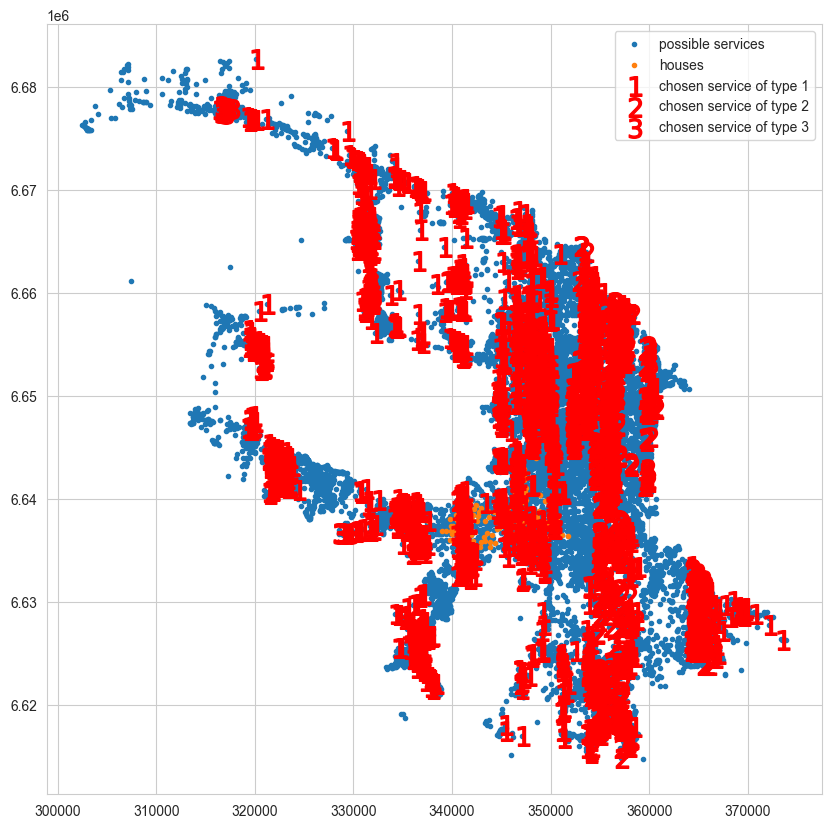

In [39]:
fig = plt.figure(figsize = (10,10))

plt.scatter(services_xy[:,0], services_xy[:,1], s=9, label = 'possible services')
plt.scatter(houses_xy[:,0], houses_xy[:,1], s=9, label = 'houses')


# mark = ["*","P","d","$PS_4$"]
mark = ["$1$","$2$","$3$","$4$", "$5$"]

plt.scatter(services_xy[np.array(res[-n:]).astype(bool)][:,0],services_xy[np.array(res[-n:]).astype(bool)][:,1],
            label = f'chosen service of type 1',c = 'red',marker = "$1$",s = 200)
for l in range(1,3):
    plt.scatter(services_xy[np.array(res[-n*(l+1):-l*n]).astype(bool)][:,0],services_xy[np.array(res[-n*(l+1):-l*n]).astype(bool)][:,1],
                marker = mark[l], label = f'chosen service of type {l+1}',c = 'red', s = 200)


#plt.scatter(PS_xy[:,0],PS_xy[:,1], s=(4*r*square_side*square_side*int(fig.dpi))^2, facecolors='none', edgecolors='r')

#print('influence radius: R = ',r)
print(f'использовано кварталов  = {sum(res[-m*k:])} из {p} возможных')
# print("удовлетворено:", model.objective.value(),f'кварталов из 241 кварталов')
plt.legend(bbox_to_anchor=(1., 1))
plt.show()

In [38]:
len(res[-m:])

119

In [63]:
V

array([[V_00_000, V_01_000, V_02_000, V_03_000, V_04_000],
       [V_00_001, V_01_001, V_02_001, V_03_001, V_04_001],
       [V_00_002, V_01_002, V_02_002, V_03_002, V_04_002],
       ...,
       [V_00_1120, V_01_1120, V_02_1120, V_03_1120, V_04_1120],
       [V_00_1121, V_01_1121, V_02_1121, V_03_1121, V_04_1121],
       [V_00_1122, V_01_1122, V_02_1122, V_03_1122, V_04_1122]],
      dtype=object)

In [59]:
services_xy[np.array(res[-m:]).astype(bool)]

array([[ 343716.38127098, 6638243.31639399],
       [ 347136.99346656, 6648567.0319999 ],
       [ 349130.81594867, 6651447.52111612],
       [ 358250.29468346, 6646573.23492771],
       [ 363735.01923062, 6625991.35472012]])

In [58]:
l=0
services_xy[np.array(res[-m*(l+1):-l*m]).astype(bool)][:,0]

array([], dtype=float64)

In [36]:
services_xy[np.array(res[-m*(l+1):-l*m]).astype(bool)]

array([[ 342592.46558551, 6638316.96385817],
       [ 347153.56595894, 6648100.14542667],
       [ 349475.31155183, 6646705.98979001],
       [ 350045.82399692, 6651661.24081056],
       [ 363911.31508223, 6625986.25580239]])

In [33]:
np.array(res[-m*(l+1):-l*m])

array([False, False, False, ..., False, False, False])

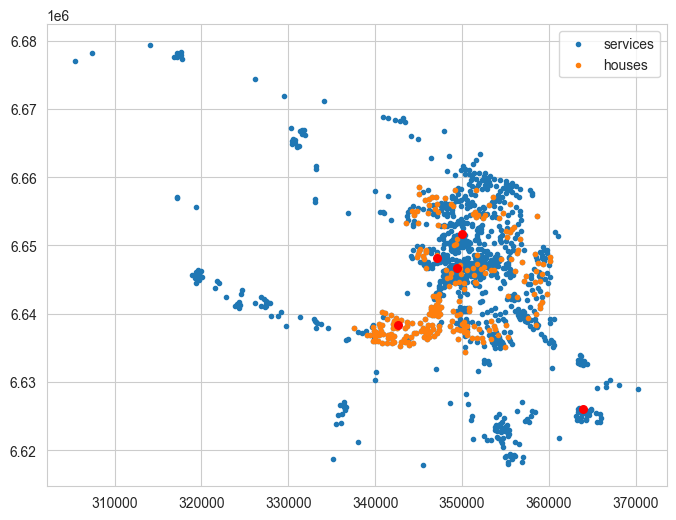

In [40]:
fig = plt.figure(figsize = (8, 6))

plt.scatter(services_xy[:,0],services_xy[:,1], s=9, label = 'services')
plt.scatter(houses_xy[:,0],houses_xy[:,1], s=9, label = 'houses')
plt.scatter( [ 363911.31508223], [6625986.25580239], s=30, c = 'red')
plt.scatter( [ 350045.82399692], [6651661.24081056], s=30, c = 'red')
plt.scatter( [ 349475.31155183], [6646705.98979001], s=30, c = 'red')
plt.scatter( [ 347153.56595894], [6648100.14542667], s=30, c = 'red')
plt.scatter( [ 342592.46558551], [6638316.96385817], s=30, c = 'red')



plt.legend()
plt.show()

In [46]:
a = [i for i in range(0,5)]
print(a)

[0, 1, 2, 3, 4]
